In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
!pip install transformers
from transformers import BertTokenizer,BertModel
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
df1=pd.read_csv('https://raw.githubusercontent.com/rachitban/SemEval2020-Task4-Commonsense-Validation-and-Explanation/master/Training%20%20Data/subtaskA_data_all.csv',sep=',')
df1

,id,sent0,sent1
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.
1,1,He drinks apple.,He drinks milk.
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today"
3,3,A mosquito stings me,I sting a mosquito
4,4,A niece is a person.,A giraffe is a person.
...,...,...,...
9995,9995,Mark ate a big bitter cherry pie,Mark ate a big sweet cherry pie
9996,9996,Gloria wears a cat on her head,Gloria wears a hat on her head
9997,9997,Harry went to the barbershop to have his hair cut,Harry went to the barbershop to have his glass...
9998,9998,Reilly is sleeping on the couch,Reilly is sleeping on the window


In [ ]:
df2=pd.read_csv('https://raw.githubusercontent.com/rachitban/SemEval2020-Task4-Commonsense-Validation-and-Explanation/master/Training%20%20Data/subtaskA_answers_all.csv',sep=',',names=['id','ans'])
df2

,id,ans
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
9995,9995,0
9996,9996,0
9997,9997,1
9998,9998,1


In [ ]:
s1=list(df1.sent0)
s2=list(df1.sent1)


In [ ]:
i=0
ans1=[]
ans2=[]
for ans in df2.ans:
  if(ans==0):
    ans1.append(0)
    ans2.append(1)
  else:
    ans1.append(1)
    ans2.append(0)
  i=i+1

In [ ]:
f1={'sent':s1,'ans':ans1}
o1=pd.DataFrame(f1)

f2={'sent':s2,'ans':ans2}
o2=pd.DataFrame(f2)

frames=[o1,o2]

main_df=pd.concat(frames)

In [ ]:
main_df.sample(frac=1)

,sent,ans
5947,"it's a good time to exercise outside, because ...",1
2560,I grind coffee beans to prepare a cappuccino,1
5310,he had a steak and a green bike,0
8824,a funeral is a place for mourning,1
5007,The sand on the road reflects the pure blue sky,0
...,...,...
7177,I like swimming in the swimming pool.,1
6382,3d printing can print car,1
365,Bill has got two friends in Belgic,1
3813,a garden hose is used for watering the garden,1


In [ ]:
# change the runtime type to GPU in Colab

if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
class MyClass(nn.Module):
  def __init__(self):
    super(MyClass,self).__init__()
    self.fc1=nn.Linear(768,20)
    self.fc2=nn.Linear(20,1)
    self.Relu=F.relu
    self.Sigmoid=torch.sigmoid

  def forward(self,sentence):
    
    #output=self.model(sentence1)
    output=self.fc1(sentence)
    output=self.Relu(output)
    output=self.fc2(output) 
    y=self.Sigmoid(output)
    return y



In [ ]:
model=MyClass()
# model.load_state_dict(torch.load('taskA_1.pt')) # comment this in case model is not saved 1st time
model.to(device)
loss_fct=nn.BCELoss()
optimizer=optim.Adam(model.parameters())

In [ ]:
train_df=main_df[0:10000]

test_df=main_df[18000:20000]

5905


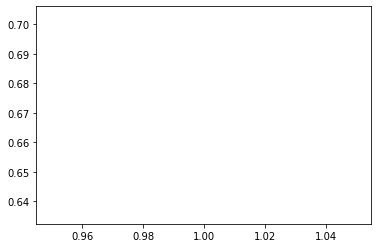

6341


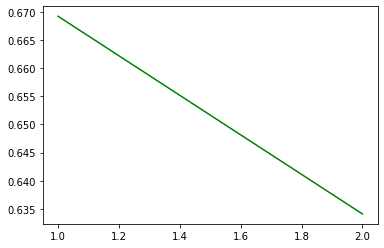

6576


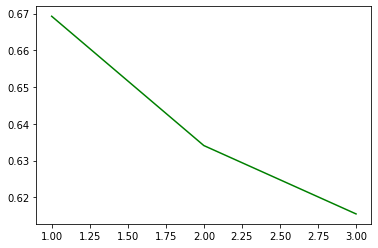

6705


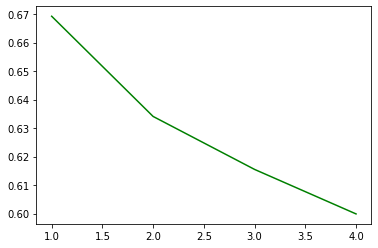

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
bertmodel=BertModel.from_pretrained('bert-base-uncased')
bertmodel.to(device)

x=[]
y=[]
plt.figure()
for epoch in range (4):
  l1=0
  correct=0
  j=0
  for i in train_df.values:

    tokenize_input=tokenizer.tokenize(i[0])
    sentence=torch.tensor([tokenizer.encode(tokenize_input,add_special_tokens=True)])

    embeddings=bertmodel(sentence.to(device))
    y_pred=model(embeddings[0][0][0].to(device))
    
    loss=loss_fct(y_pred.to(device),torch.FloatTensor([i[1]]).to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if((y_pred.data[0]<0.5 and i[1]==0) or (y_pred.data[0]>=0.5 and i[1]==1)):
      correct+=1
  
    j+=1
    l1+=loss.data
    # print(epoch,j)

  y.append(l1/j)
  x.append(epoch+1)
  print(correct)
  plt.plot(x,y,'g')
  plt.show()
plt.show() 

In [ ]:
torch.save(model.state_dict(),'taskA_1.pt')

In [ ]:
correct=0

for i in test_df.values:

    tokenize_input=tokenizer.tokenize(i[0])
    sentence=torch.tensor([tokenizer.encode(tokenize_input,add_special_tokens=True)])
    embeddings=bertmodel(sentence.to(device))
    y_pred=model(embeddings[0][0][0].to(device))

    if((y_pred.data[0]<0.5 and i[1]==0) or (y_pred.data[0]>=0.5 and i[1]==1)):
      correct+=1

print(correct)

1080
